In [1]:
import pandas as pd
import numpy as np

# Repair data

In [2]:
repairtrain=pd.read_csv('RepairTrain.csv')

In [7]:
repairtrain['repair_date']=pd.to_datetime(repairtrain['year/month(repair)'])
repairtrain['sale_date']=pd.to_datetime(repairtrain['year/month(sale)'])

In [10]:
repairtrain.drop(columns=['year/month(sale)','year/month(repair)'],inplace=True)

In [12]:
repairtrain.isna().sum()

module_category       0
component_category    0
number_repair         0
repair_date           0
sale_date             0
dtype: int64

In [45]:
repairtrain['sale_date']=repairtrain['sale_date'].dt.date 
repairtrain['repair_date']=repairtrain['repair_date'].dt.date

In [51]:
cols=['module_category', 'component_category', 'sale_date','repair_date','number_repair']
repairtrain= repairtrain[cols]

In [53]:
repairtrain.sort_values(['module_category', 'component_category','sale_date','repair_date'],inplace=True)

In [56]:
repairtrain=repairtrain.groupby(['module_category', 'component_category','sale_date','repair_date'])['number_repair'].sum().to_frame()

In [58]:
repairtrain.reset_index(inplace=True)

In [77]:
repairtrain['days_until_repair']=(repairtrain['repair_date']-repairtrain['sale_date']).apply(lambda x: x.days)

In [90]:
repairtrain['months_until_repair']=np.round((repairtrain['repair_date']-repairtrain['sale_date'])/np.timedelta64(1, 'M'))

In [94]:
repairtrain

,module_category,component_category,sale_date,repair_date,number_repair,days_until_repair,months_until_repair
0,M1,P02,2006-01-01,2007-06-01,1,516,17.0
1,M1,P02,2006-02-01,2006-09-01,2,212,7.0
2,M1,P02,2006-02-01,2006-11-01,1,273,9.0
3,M1,P02,2006-02-01,2006-12-01,1,303,10.0
4,M1,P02,2006-02-01,2007-08-01,2,546,18.0
...,...,...,...,...,...,...,...
54383,M9,P31,2006-09-01,2007-12-01,1,456,15.0
54384,M9,P31,2006-09-01,2008-02-01,1,518,17.0
54385,M9,P31,2006-09-01,2008-07-01,1,669,22.0
54386,M9,P31,2006-09-01,2008-08-01,1,700,23.0


In [95]:
repairtrain.set_index(['module_category', 'component_category','sale_date'], inplace=True)

# Sale data

In [18]:
saletrain=pd.read_csv('SaleTrain.csv')

In [19]:
saletrain['sale_date']=pd.to_datetime(saletrain['year/month'])

In [20]:
saletrain.drop(columns=['year/month'],inplace=True)

In [80]:
saletrain.columns

Index(['module_category', 'component_category', 'number_sale', 'sale_date'], dtype='object')

In [81]:
saletrain=saletrain.groupby(['module_category', 'component_category', 'sale_date'])['number_sale'].sum().to_frame()

In [96]:
saletrain.set_index(['module_category', 'component_category', 'sale_date'],inplace=True)

# Output Target Data

In [39]:
out_target=pd.read_csv('Output_TargetID_Mapping.csv')

In [43]:
out_target.year

0       2010
1       2010
2       2010
3       2010
4       2010
        ... 
4251    2011
4252    2011
4253    2011
4254    2011
4255    2011
Name: year, Length: 4256, dtype: int64

# Model

In [140]:
df_input=repairtrain.copy()
df_input['number_sale']=saletrain['number_sale']

In [141]:
df_input.reset_index(inplace=True)

In [142]:
df_input.isna().sum()

module_category           0
component_category        0
sale_date                 0
repair_date               0
number_repair             0
days_until_repair         0
months_until_repair       0
number_sale            2131
dtype: int64

In [143]:
df_input['sale_months']=np.round((df_input['sale_date']-df_input['sale_date'].min())/np.timedelta64(1, 'M'))
df_input['repair_months']=np.round((df_input['repair_date']-df_input['sale_date'].min())/np.timedelta64(1, 'M'))

In [146]:
df_input.drop(columns=['sale_date','repair_date'],inplace=True)

In [147]:
df_input['event']=1

In [166]:
df_input['freq']=df_input['number_repair']

In [167]:
final_repair_date=df_input['repair_months'].max()-df_input['sale_months'].min()

def add_censor(x):
    new_row = pd.DataFrame(x.iloc[-1, :]).transpose()

    new_row['repair_months'] = final_repair_date

    new_row['months_until_repair'] = new_row['repair_months'] - new_row['sale_months']

    new_row['event'] = 0
    
    new_row['freq'] = new_row['number_sale'] - sum(x['freq'])
    
    return x.append(new_row)

In [173]:
df_input=df_input.dropna().groupby(['module_category', 'component_category', 'sale_months']).apply(add_censor).reset_index(drop = True)

In [174]:
df_input.head(10)

,module_category,component_category,number_repair,days_until_repair,months_until_repair,number_sale,sale_months,repair_months,event,freq
0,M1,P02,2,212,7.0,2856.0,35.0,42.0,1,2
1,M1,P02,1,273,9.0,2856.0,35.0,44.0,1,1
2,M1,P02,1,303,10.0,2856.0,35.0,45.0,1,1
3,M1,P02,2,546,18.0,2856.0,35.0,53.0,1,2
4,M1,P02,1,699,23.0,2856.0,35.0,58.0,1,1
5,M1,P02,1,759,25.0,2856.0,35.0,60.0,1,1
6,M1,P02,1,790,26.0,2856.0,35.0,61.0,1,1
7,M1,P02,1,790,46.0,2856.0,35.0,81.0,0,2847.0
8,M1,P02,1,122,4.0,28672.0,36.0,40.0,1,1
9,M1,P02,1,184,6.0,28672.0,36.0,42.0,1,1


## NelsonAalenFitter

In [2]:
from lifelines import NelsonAalenFitter
import lifelines

In [182]:
naf = lifelines.NelsonAalenFitter(nelson_aalen_smoothing = False)
comp_hazard = pd.DataFrame(columns = ['component_category', 'months_until_repair', 'hazard'])

In [ ]:
for component in df_input['component_category'].unique():
    print('Current component %s' % component)
    cur_df = pd.DataFrame(columns = ['component_category', 'months_until_repair', 'hazard'])
    df_input_specific = df_input[df_input['component_category'].str.match(component)]
    naf.fit(durations = df_input_specific['months_until_repair'], event_observed = df_input_specific['event'], weights = df_input_specific['freq'])
    cur_df['months_until_repair'] = naf.cumulative_hazard_.index
    cur_df['hazard'] = naf.cumulative_hazard_.diff().fillna(0).values
    cur_df['component_category'] = component
    comp_hazard = pd.concat([comp_hazard, cur_df])
    naf.plot_hazard(bandwidth=3)
plt.show()

# Telco Customer Churn

In [3]:
data=pd.read_csv('Telco-Customer-Churn.csv')

In [4]:
data['churn'] = [1 if x == 'Yes' else 0 for x in data['Churn']]

In [5]:
from lifelines import KaplanMeierFitter ,NelsonAalenFitter
from lifelines.statistics import (logrank_test, 
                                  pairwise_logrank_test, 
                                  multivariate_logrank_test, 
                                  survival_difference_at_fixed_point_in_time_test)

<AxesSubplot:xlabel='timeline'>

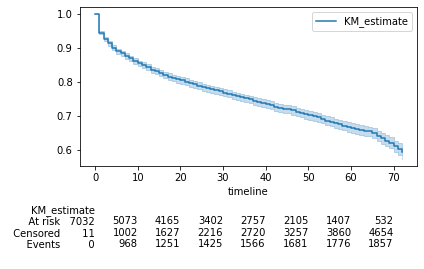

In [6]:
T = data['tenure']
E = data['churn']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

kmf.plot(at_risk_counts=True)

<AxesSubplot:xlabel='timeline'>

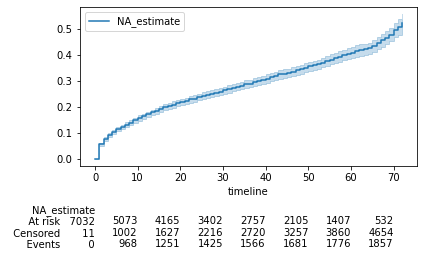

In [196]:
naf = NelsonAalenFitter()
naf.fit(T, event_observed=E)

naf.plot(at_risk_counts=True)

In [33]:
df=data[['tenure','churn']].sort_values('tenure')

In [99]:
R=df.groupby('tenure')['churn'].agg(['count','sum'])

In [100]:
total=R['count'].sum()
total

7043

In [101]:
R['cumcnt']=R.cumsum()['count']

In [102]:
R['shift']=R['cumcnt'].shift()

In [103]:
R.fillna(0,inplace=True)

In [104]:
R.head()

,count,sum,cumcnt,shift
tenure,,,,
0,11,0,11,0.0
1,613,380,624,11.0
2,238,123,862,624.0
3,200,94,1062,862.0
4,176,83,1238,1062.0


In [105]:
R['r']=1-R['sum']/(total-R['shift'])

<AxesSubplot:xlabel='tenure'>

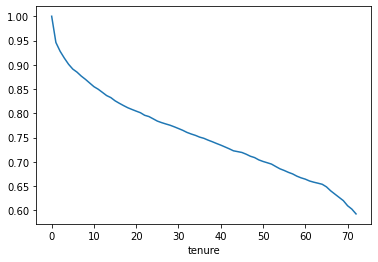

In [107]:
R.cumprod()['r'].plot()

In [28]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
1.0,0.945961
2.0,0.927835
3.0,0.913725
4.0,0.901045
...,...
68.0,0.626858
69.0,0.620135
70.0,0.609657


In [81]:
R.r

tenure
0     1.000000
1     0.946046
2     0.981540
3     0.985627
4     0.987124
        ...   
68    0.998274
69    0.998463
70    0.997883
71    0.998843
72    0.998842
Name: r, Length: 73, dtype: float64

In [109]:
data_mela=pd.read_clipboard()

In [110]:
data_mela

,,,Initial,Treatment,Remission,Survival
Patient,Age,Gender,Stage,Received,Duration,Time
1,59,2,3B,1,33.7,33.7
2,50,2,3B,1,3.8,3.9
3,76,1,3B,1,6.3,10.5
4,66,2,3B,1,2.3,5.4
5,33,1,3B,1,6.4,19.5
6,23,2,3B,1,23.8,23.8
7,40,2,3B,1,1.8,7.9
8,34,1,3B,1,5.5,16.9
9,34,1,3B,1,16.6,16.6


In [113]:
data_mela.Survival.iloc[3]

'10.5'

In [114]:
data_rat=pd.read_clipboard()

In [117]:
data_rat.Saturated.iloc[-1]

'200\x01'